In [11]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.utils import AirPassengersDF
import yfinance as yf
from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.losses.pytorch import MQLoss, PMM, MAE

In [2]:
def load_data():
    id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
    ticker_to_name_path = "Datasets/kaggle/Company.csv"

    tickers_df = pd.read_csv(id_to_ticker_path)
    company_name_df = pd.read_csv(ticker_to_name_path)
    tickers = company_name_df.ticker_symbol.tolist()

    market_data = yf.download((' ').join(tickers), start="2015-01-01", end="2020-01-01", group_by = 'ticker')

    returns = pd.DataFrame()
    
    # for ticker in market_data.columns.levels[0]:
    #     returns[ticker] = market_data[ticker].Close.pct_change(1).dropna()

    for ticker in market_data.columns.levels[0]:
        returns[ticker] = market_data[ticker].Close.shift(-1).dropna()

    market_data = market_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)

    # market_data['Returns'] = None
    # market_data['Returns'][:-6] = returns.values.flatten()

    # market_data['Close_next'] = None
    # market_data['Close_next'][:-6] = returns.values.flatten()

    # market_data = market_data.fillna(market_data.Returns.mean())
    market_data = market_data.dropna()
    market_data = market_data.reset_index()

    market_data.to_csv('Datasets/market/market.csv', index=False)

    return market_data

In [3]:
data = load_data()
data

[*********************100%***********************]  6 of 6 completed


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume
0,2015-01-02,AAPL,24.603207,27.332500,27.860001,26.837500,27.847500,212818400
1,2015-01-02,AMZN,15.426000,15.426000,15.737500,15.348000,15.629000,55664000
2,2015-01-02,GOOG,26.168653,26.168653,26.490770,26.133251,26.378078,28951268
3,2015-01-02,GOOGL,26.477501,26.477501,26.790001,26.393999,26.629999,26480000
4,2015-01-02,MSFT,40.811420,46.759998,47.419998,46.540001,46.660000,27913900
...,...,...,...,...,...,...,...,...
7543,2019-12-31,AMZN,92.391998,92.391998,92.663002,91.611504,92.099998,50130000
7544,2019-12-31,GOOG,66.850998,66.850998,66.900002,66.454247,66.505501,19236000
7545,2019-12-31,GOOGL,66.969498,66.969498,67.032997,66.606499,66.789497,19514000
7546,2019-12-31,MSFT,153.313202,157.699997,157.770004,156.449997,156.770004,18369400


In [4]:
Y_df = data[['Ticker', 'Date', 'Close']].rename(columns={
    "Ticker": "unique_id",
    "Date": "ds",
    "Close": "y"
})

In [5]:
Y_df

,unique_id,ds,y
0,AAPL,2015-01-02,27.332500
1,AMZN,2015-01-02,15.426000
2,GOOG,2015-01-02,26.168653
3,GOOGL,2015-01-02,26.477501
4,MSFT,2015-01-02,46.759998
...,...,...,...
7543,AMZN,2019-12-31,92.391998
7544,GOOG,2019-12-31,66.850998
7545,GOOGL,2019-12-31,66.969498
7546,MSFT,2019-12-31,157.699997


In [6]:
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.1 * n_time)

In [7]:
val_size, test_size

(251, 125)

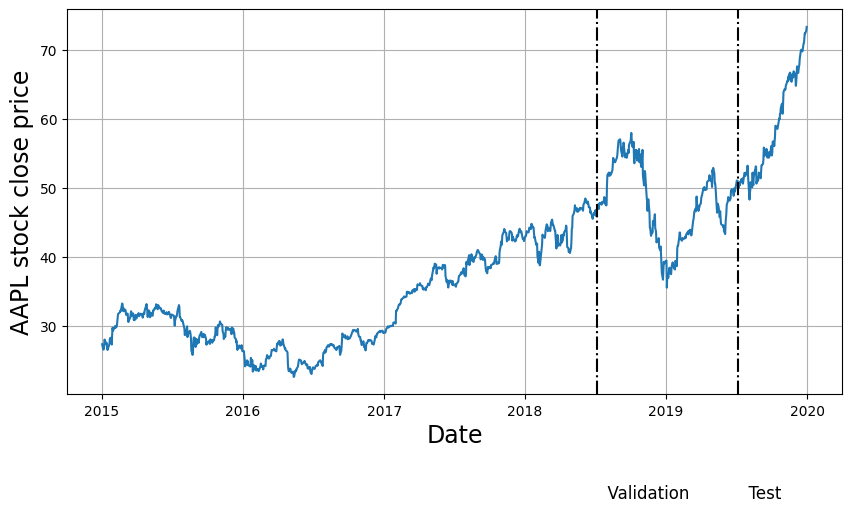

In [8]:
u_id = 'AAPL'
x_plot = Y_df[Y_df.unique_id==u_id].ds
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot.iloc[n_time - val_size - test_size]
x_test = x_plot.iloc[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('AAPL stock close price', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()
plt.show()
plt.close()

In [9]:
Y_df.unique_id.unique()

array(['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA'], dtype=object)

In [13]:
model = NHITS(h=5, input_size=14,
              loss=MAE(),
              #loss=MQLoss(level=[80, 90]),
            #   stat_exog_list=['airline1'],
            #   futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              scaler_type='robust',
            #   scaler_type=None,
              learning_rate=1e-3,
              max_epochs=100)

fcst = NeuralForecast(
    models=[model],
    freq='D'
)

In [15]:
fcst.fit(Y_df, val_size=val_size)

Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s, loss=1.87, v_num=10, train_loss_step=1.880, val_loss=2.000, train_loss_epoch=1.880]


In [17]:
fcst_df = fcst.cross_validation(df=Y_df, val_size=val_size,
                                test_size=test_size, n_windows=None)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


In [21]:
fcst_df

,unique_id,ds,cutoff,NHITS,y
0,AAPL,2019-08-29,2019-08-28,51.285622,52.252499
1,AAPL,2019-08-30,2019-08-28,51.276180,52.185001
2,AAPL,2019-08-31,2019-08-28,51.198814,NaN
3,AAPL,2019-09-01,2019-08-28,51.152443,NaN
4,AAPL,2019-09-02,2019-08-28,51.228016,NaN
...,...,...,...,...,...
3625,TSLA,2019-12-27,2019-12-26,28.105949,28.691999
3626,TSLA,2019-12-28,2019-12-26,27.979454,NaN
3627,TSLA,2019-12-29,2019-12-26,28.346832,NaN
3628,TSLA,2019-12-30,2019-12-26,28.595779,27.646667


In [24]:
y_true = fcst_df.y.values
y_hat = fcst_df['NHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, 5)
y_hat = y_hat.reshape(n_series, -1, 5)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (6, 121, 5)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (6, 121, 5)


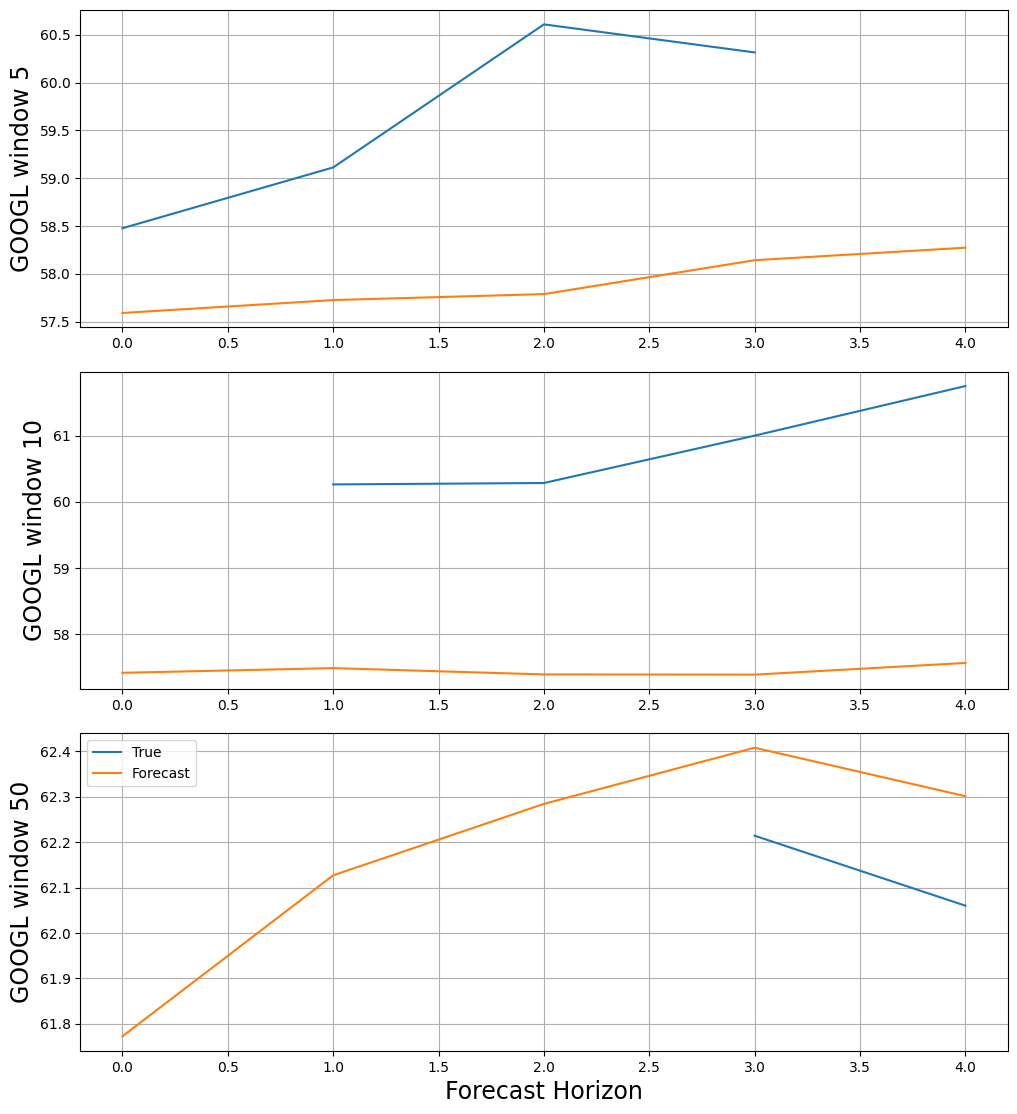

In [26]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA']
series_idx = 3

for idx, w_idx in enumerate([5, 10, 50]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

In [ ]:
y_true = fcst_df.y.values
y_hat = fcst_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA']
series_idx = 3

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(f'{series[series_idx]} window {w_idx}', fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_df[Y_df.unique_id=='AAPL'], Y_hat_df[Y_hat_df.unique_id=='AAPL']]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('Stock Price Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [35]:
Y_train_df

,unique_id,ds,y
0,AAPL,2015-01-02,27.332500
1,AMZN,2015-01-02,15.426000
2,GOOG,2015-01-02,26.168653
3,GOOGL,2015-01-02,26.477501
4,MSFT,2015-01-02,46.759998
...,...,...,...
7423,AMZN,2019-12-02,89.080002
7424,GOOG,2019-12-02,64.496002
7425,GOOGL,2019-12-02,64.443001
7426,MSFT,2019-12-02,149.550003


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.67it/s]


[]

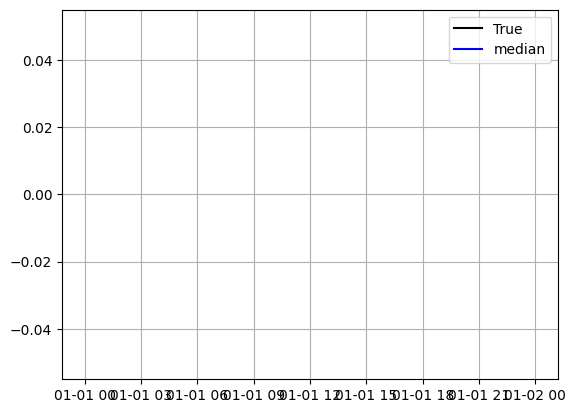

In [37]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-120]]
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-120]].reset_index(drop=True) # 12 test

model = NHITS(h=12, input_size=24,
              loss=MAE(),
              #loss=MQLoss(level=[80, 90]),
              #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
            #   stat_exog_list=['airline1'],
            #   futr_exog_list=['trend'],
              n_freq_downsample=[2, 1, 1],
              #scaler_type='robust',
              scaler_type=None,
              learning_rate=1e-3,
              max_epochs=100)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)

fcst.fit(Y_train_df, val_size=200)
forecasts = fcst.predict(futr_df=Y_test_df)

[]

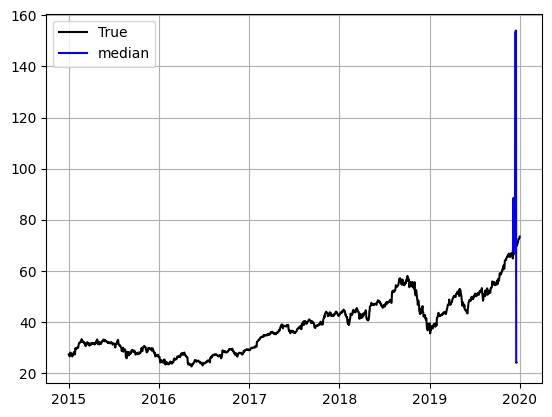

In [38]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='AAPL'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
try:
    plt.plot(plot_df['ds'], plot_df['NHITS-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'], 
                     y1=plot_df['NHITS-lo-90.0'], y2=plot_df['NHITS-hi-90.0'],
                     alpha=0.4, label='level 90')
except:
    plt.plot(plot_df['ds'], plot_df['NHITS'], c='blue', label='median')
plt.legend()
plt.grid()
plt.plot()